# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package. 

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)

Note: Generative AI was partially used in this assignment's implementation and debugging.

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[Ep   10] avg_ret=-500.00  eps=0.980  loss=58.26546
[Ep   20] avg_ret=-500.00  eps=0.960  loss=4.48764
[Ep   30] avg_ret=-500.00  eps=0.941  loss=7.35815
[Ep   40] avg_ret=-488.00  eps=0.921  loss=3.79711
[Ep   50] avg_ret=-490.40  eps=0.901  loss=5.26701
[Ep   60] avg_ret=-478.10  eps=0.881  loss=1.15035
[Ep   70] avg_ret=-431.30  eps=0.861  loss=6.95079
[Ep   80] avg_ret=-419.80  eps=0.842  loss=2.84687
[Ep   90] avg_ret=-442.70  eps=0.822  loss=6.49912
[Ep  100] avg_ret=-443.10  eps=0.802  loss=5.91326
[Ep  110] avg_ret=-374.40  eps=0.782  loss=6.73458
[Ep  120] avg_ret=-357.20  eps=0.762  loss=7.92015
[Ep  130] avg_ret=-398.60  eps=0.743  loss=9.04009
[Ep  140] avg_ret=-336.20  eps=0.723  loss=4.99575
[Ep  150] avg_ret=-284.20  eps=0.703  loss=4.17413
[Ep  160] avg_ret=-226.20  eps=0.683  loss=3.88708
[Ep  170] avg_ret=-298.70  eps=0.664  loss=4.28849
[Ep  180] avg_ret=-235.50  eps=0.644  loss=6.41724
[Ep  190] avg_ret=-210.40  eps=0.624  l

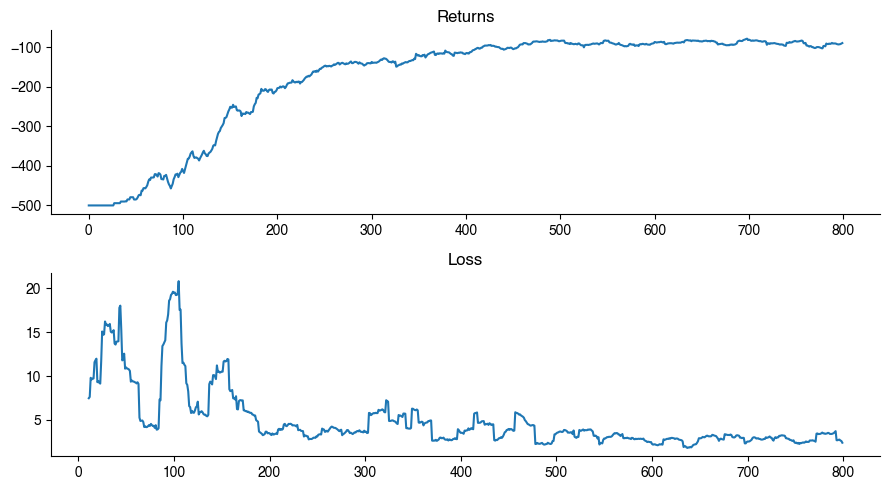

In [ ]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    # TODO 1.1: Implement a simple MLP
    #########################################
    def __init__(self, in_dim: int, out_dim: int, hidden: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
   

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
   #########################################
    # TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions
    #########################################
    def push(self, s, a, r, ns, d):
        transition = (s, a.long(), r, ns, d)
        if len(self.mem) < self.capacity:
            self.mem.append(transition)
        else:
            self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int):
        batch = random.sample(self.mem, batch_size)
        s, a, r, ns, d = zip(*batch)
        s  = torch.cat(s,  dim=0)        # [B, obs]
        a  = torch.cat(a,  dim=0)        # [B, 1]
        r  = torch.cat(r,  dim=0)        # [B, 1]
        ns = torch.cat(ns, dim=0)        # [B, obs]
        d  = torch.cat(d,  dim=0)        # [B, 1] bool
        return s, a, r, ns, d
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []
    total_steps = 0
    last_loss = np.nan

    eps_min, eps_max = 0.05, 1.0
    def eps_by_ep(ep_idx):
        frac = max(0.0, 1.0 - ep_idx / (0.6 * MAX_EPISODES))
        return eps_min + (eps_max - eps_min) * frac

    for ep in range(1, MAX_EPISODES + 1):
        state, _ = env.reset(seed=SEED + ep)
        done = False
        ep_return = 0.0
        eps = eps_by_ep(ep)

        while not done:
            action = act_epsilon_greedy(state, eps)
            next_state, reward, done_t, _ = env.step(action)
            done = bool(done_t.item())
            ep_return += reward.item()

            buffer.push(state, action, reward, next_state, done_t)
            state = next_state
            total_steps += 1

            # Learn
            if len(buffer.mem) >= BATCH_SIZE and total_steps >= START_TRAINING_AFTER:
                s, a, r, ns, d = buffer.sample(BATCH_SIZE)
                q_sa = q_net(s).gather(1, a)

                # ---------- Single DQN target ----------
                # with torch.no_grad():
                #     q_next = tgt_net(ns)
                #     max_next = q_next.max(dim=1, keepdim=True)[0]
                #     not_done = (~d).float()
                #     target = r + GAMMA * not_done * max_next

                # ---------- Double DQN target ----------
                with torch.no_grad():
                    next_argmax = q_net(ns).argmax(dim=1, keepdim=True)
                    q_next_sel = tgt_net(ns).gather(1, next_argmax)
                    not_done = (~d).float()
                    target = r + GAMMA * not_done * q_next_sel

                loss = F.mse_loss(q_sa, target)
                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()
                last_loss = loss.item()

                if (total_steps % TARGET_UPDATE_FREQ) == 0:
                    tgt_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_return)
        loss_hist.append(last_loss)

        if (ep % PRINT_EVERY_EPISODES) == 0:
            avg_ret = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            print(f"[Ep {ep:4d}] avg_ret={avg_ret:7.2f}  eps={eps:.3f}  loss={last_loss if not np.isnan(last_loss) else float('nan'):.5f}")

    # Plot ONCE at the end
    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines. 

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

---
Completed in the code above.

---

## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2} 
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that 

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.



Per-estimator mean per-parameter std:
  REINFORCE (full): 11.512451
  REINFORCE (RtG) : 26.110147
  Baseline V      : 19.108097
  Q               : 20.569901
  Advantage       : 17.293926
  TD(δ)           : 19.108097

Per-estimator normalized mean per-parameter std:
  REINFORCE (full): 0.136821
  REINFORCE (RtG) : 0.128640
  Baseline V      : 0.127700
  Q               : 0.129232
  Advantage       : 0.130502
  TD(δ)           : 0.127700


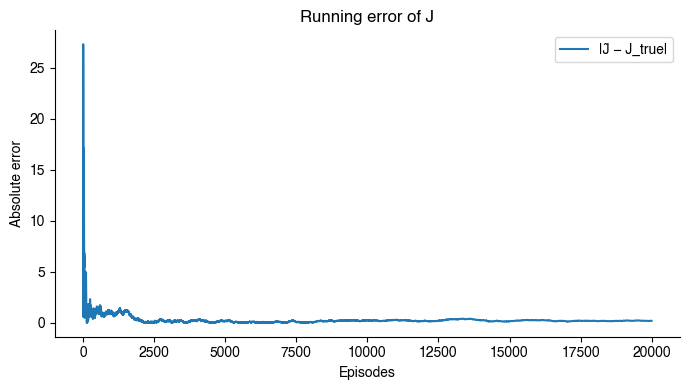

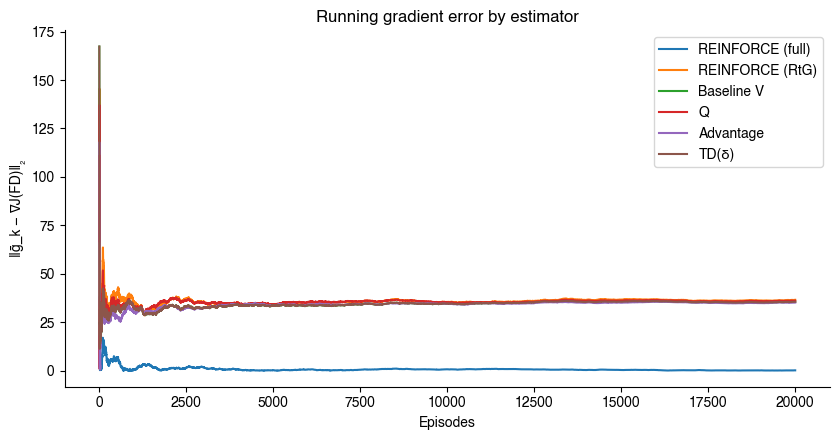

In [19]:
import math, random
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    # TODO 2.1: Implement the policy network
    #########################################
    def __init__(self, hidden: int = 8):
        super().__init__()
        # input is scalar x = s/N
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, 2)  # actions: L,R

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (B,) or (B,1)
        if x.dim() == 1:
            x = x.unsqueeze(1)
        z = F.relu(self.fc1(x))
        logits = self.fc2(z)
        return F.softmax(logits, dim=-1)
    

# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32)
        x = s_idx / float(N)                  # (N-1,)
        pi = model(x)                         # (N-1, 2)
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()
    
    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)

    B = int(s0_batch.numel())
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded
    
    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)

    # Per-episode accumulators
    S_sum    = torch.zeros(B, P, device=device)  # ∑_t ∇θ log π(a_t|s_t) for g1
    base_acc = torch.zeros(B, P, device=device)  # ∑_t V(s_t) ∇θ log π(a_t|s_t) for g3

    while not torch.all(done):
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()
        
        #########################################
        # TODO 2.1: Implement the six policy gradient estimators
        # Batched, eligibility-trace style (H), consistent with F2–F6.
        #########################################

        # 1) Discounted eligibility: H_t = γ H_{t-1} + ∇θ log π(a_t|s_t)
        H[idx] = gamma * H[idx] + score_mat  # (B_act, P)

        # 2) Track J(τ) online and total score sum for REINFORCE(full)
        J[idx]    = J[idx] + gpw[idx] * r_t                 # discounted return accumulator
        S_sum[idx] += score_mat                             # ∑ ∇logπ_t
        gpw[idx]   = gpw[idx] * gamma                       # γ^{t+1}

        # 3) g2: return-to-go REINFORCE via identity  Σ_t r_t H_t  =  Σ_t G_t ∇logπ_t
        g2[idx] += r_t.unsqueeze(1) * H[idx]                # (B_act, P)

        # 4) g3: baseline with V(s_t): g3 = Σ_t (G_t − V(s_t)) ∇logπ_t
        # Using Σ_t r_t H_t − Σ_t V(s_t) ∇logπ_t
        if V is not None:
            v_s = V[s[idx]].unsqueeze(1)                    # (B_act, 1)
            base_acc[idx] += v_s * score_mat                # accumulate Σ_t V(s_t) ∇logπ_t

        # 5) g4: using Q(s_t,a_t): g4 = Σ_t Q(s_t,a_t) ∇logπ_t
        if Q is not None:
            q_sa = Q[s[idx], a]                             # (B_act,)
            g4[idx] += q_sa.unsqueeze(1) * score_mat

        # 6) g5: advantage: g5 = Σ_t (Q − V)(s_t,a_t) ∇logπ_t
        if (Q is not None) and (V is not None):
            adv = (q_sa - V[s[idx]])                        # (B_act,)
            g5[idx] += adv.unsqueeze(1) * score_mat

        # 7) g6: TD residual with eligibility: g6 = Σ_t δ_t H_t
        if V is not None:
            v_s      = V[s[idx]]
            v_s_next = V[s_next.clamp(min=0, max=N)]
            delta = r_t + gamma * v_s_next - v_s            # (B_act,)
            g6[idx] += delta.unsqueeze(1) * H[idx]

        # Advance environment state and mark terminations
        s[idx]    = s_next
        done[idx] = term_any

        # Finalize any episodes that terminated on this step
        if term_any.any():
            fidx = idx[term_any]
            # g1 (REINFORCE full return): (Σ_t ∇logπ_t) * G(τ)
            g1[fidx] = J[fidx].unsqueeze(1) * S_sum[fidx]
            # Finish baseline correction for g3: g3 = g2 − Σ_t V(s_t) ∇logπ_t
            if V is not None:
                g3[fidx] = g2[fidx] - base_acc[fidx]
        #########################################

        
    return (g1.detach().cpu().numpy(),
            g2.detach().cpu().numpy(),
            (g3.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g4.detach().cpu().numpy() if Q is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g5.detach().cpu().numpy() if (V is not None and Q is not None) else np.zeros_like(g2.detach().cpu().numpy())),
            g6.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy()),
            J.detach().cpu().numpy())

# ----------------- main -----------------
set_seed(0)
device = torch.device("cpu")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0

# Policy
model = PolicyNet(hidden=2).to(device)

# Exact J and FD gradient
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)

# Baselines from DP value V(s) and Q(s,a)
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

#########################################
# TODO 2.1: Plot your result here
# 1) Print per-estimator dispersion summaries
# 2) Plot running |Ĵ − J_true|
# 3) Plot running ‖ḡ_k − ∇J(FD)‖₂ for each estimator
#########################################

def mean_param_std(G):
    return float(G.std(axis=0).mean())

def mean_param_std_normalized(G):
    norms = np.linalg.norm(G, axis=1, keepdims=True)  # per-episode L2
    Gn = G / (norms + 1e-8)
    return float(Gn.std(axis=0).mean())

names = ["REINFORCE (full)", "REINFORCE (RtG)", "Baseline V", "Q", "Advantage", "TD(δ)"]
Gs    = [g1, g2, g3, g4, g5, g6]

print("\nPer-estimator mean per-parameter std:")
for n, G in zip(names, Gs):
    print(f"  {n:16s}: {mean_param_std(G):.6f}")

print("\nPer-estimator normalized mean per-parameter std:")
for n, G in zip(names, Gs):
    print(f"  {n:16s}: {mean_param_std_normalized(G):.6f}")

# (2) Running absolute error on J
J_true_scalar   = float(J_true)
running_J_mean  = np.cumsum(J, axis=0) / np.arange(1, len(J) + 1)
J_abs_err       = np.abs(running_J_mean.squeeze() - J_true_scalar)

plt.figure(figsize=(7,4))
plt.plot(J_abs_err, label="|Ĵ − J_true|")
plt.xlabel("Episodes"); plt.ylabel("Absolute error"); plt.title("Running error of J")
plt.legend(); plt.tight_layout(); plt.show()

# (3) Running gradient L2 error vs finite-difference gradient
grad_true = grad_fd.detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(8.5,4.5))
for n, G in zip(names, Gs):
    cum = np.cumsum(G, axis=0)
    k   = np.arange(1, G.shape[0] + 1)[:, None]
    Gbar = cum / k
    err = np.linalg.norm(Gbar - grad_true[None, :], axis=1)
    plt.plot(err, label=n)
plt.xlabel("Episodes"); plt.ylabel("‖ḡ_k − ∇J(FD)‖₂")
plt.title("Running gradient error by estimator")
plt.legend(); plt.tight_layout(); plt.show()


----

## Comments

The first plot illustrates the running error of the Monte Carlo estimate of the expected return $J$ relative to the dynamic programming ground truth $J_{\text{true}}$. 
The absolute error decreases sharply during the first few hundred episodes and then stabilizes near zero, indicating that the Monte Carlo average is an unbiased and consistent estimator of the expected return. 
The initial spike arises because of the high-variance terminal reward, which dominates early samples when the number of episodes is small.

The second plot shows the running $\ell_2$ error between the mean estimated policy gradient and the finite-difference ground truth. 
Among all estimators, the standard REINFORCE (full-return) method achieves the lowest asymptotic error, while the other estimators (return-to-go, baseline, $Q$, advantage, and TD-residual forms) converge to slightly higher bias levels. 
This inversion of the usual hierarchy - where variance-reduced estimators often perform better - occurs because the environment’s reward structure is dominated by a single large terminal reward and nearly deterministic transitions. 
In such low-stochasticity settings, the full-return estimator exhibits low variance, whereas baseline subtraction and bootstrapping introduce additional approximation noise.

The table of gradient standard deviations supports this interpretation. 
The unnormalized per-parameter standard deviation for REINFORCE (full) is approximately $11.5$, much smaller than the $26.1$ observed for the return-to-go estimator. 
After normalization by the gradient norm, all estimators have similar directional variability ($\approx 0.13$), suggesting that while they differ in magnitude, their average gradient directions are consistent. 
These results confirm that for simple one-dimensional ring environments with deterministic dynamics and sparse terminal rewards, classical REINFORCE can outperform more sophisticated variance-reduction schemes both in convergence speed and estimator stability.

----

### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$ 

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info
    
env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.2: Implement policy network
    #########################################]
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim)
        )
        # lightly regularized orthogonal init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)
    
# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    #########################################
    #TODO 2.2: Implement value network
    #########################################
    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x).squeeze(-1)
    
    
policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    #########################################
    #TODO 2.2: Implement vanilla REINFORCE algorithm
    #########################################
    policy_opt = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    value_opt  = torch.optim.Adam(vnet.parameters(),   lr=LR_VALUE)

    returns_history = []

    for epoch in range(1, MAX_EPOCHS + 1):
        # ------ collect a batch of complete episodes ------
        batch_obs, batch_acts, batch_returns, batch_T = [], [], [], []
        ep_returns = []

        while len(batch_T) < BATCH_SIZE:
            obs, _ = env.reset()
            obs = obs.to(DEVICE)  # (1, obs_dim)

            ep_O, ep_A, ep_R = [], [], []
            for t in range(MAX_EP_LEN):
                logits = policy(obs)                      # (1, act_dim)
                dist = Categorical(logits=logits)
                a = dist.sample()                         # (1,)
                next_obs, r, done, _ = env.step(a)

                ep_O.append(obs.squeeze(0))               # (obs_dim,)
                ep_A.append(a.squeeze(0).long())          # ()
                ep_R.append(r.squeeze(0))                 # ()

                obs = next_obs.to(DEVICE)
                if done.item():
                    break

            # episode tensors
            R = torch.stack(ep_R, dim=0).to(DEVICE).squeeze(-1)  # (T,)
            G = mc_returns_single_traj(R, GAMMA)                 # (T,)

            batch_obs.append(torch.stack(ep_O, dim=0))           # (T, obs)
            batch_acts.append(torch.stack(ep_A, dim=0))          # (T,)
            batch_returns.append(G)                              # (T,)
            batch_T.append(len(ep_R))
            ep_returns.append(float(R.sum().item()))

        # ------ flatten across episodes (keep local time for γ^t) ------
        O = torch.cat(batch_obs, dim=0).to(DEVICE)               # (sumT, obs)
        A = torch.cat(batch_acts, dim=0).to(DEVICE)              # (sumT,)
        G_all = torch.cat(batch_returns, dim=0).to(DEVICE)       # (sumT,)

        # per-step gamma^t (restarts each episode)
        gamma_pow = torch.cat(
            [GAMMA ** torch.arange(T, device=DEVICE, dtype=torch.float32)
             for T in batch_T],
            dim=0
        )                                                        # (sumT,)

        # ------ compute advantages using learned baseline ------
        with torch.no_grad():
            V_pred = vnet(O)                                     # (sumT,)
        A_hat = G_all - V_pred
        if A_hat.numel() > 1:
            A_hat = (A_hat - A_hat.mean()) / (A_hat.std() + 1e-8)

        # ------ policy gradient step ------
        logp = Categorical(logits=policy(O)).log_prob(A)         # (sumT,)
        pg_loss = -(logp * (gamma_pow * A_hat.detach())).mean()

        policy_opt.zero_grad(set_to_none=True)
        pg_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        policy_opt.step()

        # ------ value regression to MC returns ------
        for _ in range(VALUE_UPDATES):
            v = vnet(O)
            v_loss = F.mse_loss(v, G_all)
            value_opt.zero_grad(set_to_none=True)
            v_loss.backward()
            nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            value_opt.step()

        # ------ logging ------
        avg_ret = float(np.mean(ep_returns))
        returns_history.append(avg_ret)
        if epoch % 10 == 0:
            print(f"[Epoch {epoch:03d}] avg_return={avg_ret:7.2f}  "
                  f"pg_loss={pg_loss.item():.4f}  v_loss={v_loss.item():.4f}  "
                  f"batch_T={batch_T}")

    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")
    
eval(policy, episodes=100, greedy=True)

[Epoch 010] avg_return=-217.62  pg_loss=-0.2135  v_loss=4972.1357  batch_T=[224, 210, 192, 204, 238, 227, 228, 157, 233, 224, 240, 252, 154, 224, 257, 234]
[Epoch 020] avg_return=-152.25  pg_loss=-0.2009  v_loss=1701.0596  batch_T=[181, 159, 146, 126, 199, 157, 156, 123, 148, 129, 124, 99, 139, 175, 177, 214]
[Epoch 030] avg_return=-140.19  pg_loss=-0.1225  v_loss=1251.4951  batch_T=[139, 124, 139, 109, 117, 118, 123, 151, 125, 280, 124, 120, 236, 122, 119, 113]
[Epoch 040] avg_return=-104.44  pg_loss=-0.1203  v_loss=173.3923  batch_T=[108, 116, 85, 108, 135, 125, 92, 88, 97, 115, 114, 112, 84, 106, 93, 109]
[Epoch 050] avg_return=-127.44  pg_loss=0.1015  v_loss=2746.0984  batch_T=[110, 133, 86, 114, 72, 107, 82, 119, 121, 89, 500, 128, 102, 99, 89, 103]
[Epoch 060] avg_return= -98.19  pg_loss=-0.0093  v_loss=488.6106  batch_T=[89, 68, 92, 76, 84, 228, 78, 99, 74, 80, 90, 104, 99, 106, 108, 112]
[Epoch 070] avg_return=-103.12  pg_loss=-0.0259  v_loss=462.7665  batch_T=[88, 149, 79, 102

## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function 
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

In [ ]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 500
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 3.1: Implement policy network
    #########################################
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim)  
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)
    

class ValueNet(nn.Module):
    #########################################
    #TODO 3.1: Implement value network
    #########################################
    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x).squeeze(-1)


policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    #########################################
    #TODO 3.1: Implement the main algorithm
    #########################################
    for epoch in range(1, MAX_EPOCHS + 1):
        # ----- collect an on-policy batch of STEPS_PER_UPDATE transitions -----
        S, A, R, S2, D = [], [], [], [], []
        for _ in range(STEPS_PER_UPDATE):
            s_t = to_t(obs)                                   # (1, obs_dim)
            with torch.no_grad():
                logits = policy(s_t)                          # (1, act_dim)
                dist = Categorical(logits=logits)
                a_t = dist.sample()                           # (1,)

            next_obs, r, term, trunc, _ = env.step(int(a_t.item()))
            done = bool(term or trunc)

            # store transition (as tensors on DEVICE)
            S.append(torch.as_tensor(obs,      dtype=torch.float32, device=DEVICE))
            A.append(torch.as_tensor(a_t.item(), dtype=torch.long,   device=DEVICE))
            R.append(torch.as_tensor(r,        dtype=torch.float32, device=DEVICE))
            S2.append(torch.as_tensor(next_obs,dtype=torch.float32, device=DEVICE))
            D.append(torch.as_tensor(done,     dtype=torch.bool,    device=DEVICE))

            # episodic stats
            ep_ret += r
            ep_len += 1
            obs = next_obs
            if done:
                returns_history.append(ep_ret)
                ep_ret, ep_len = 0.0, 0
                obs, _ = env.reset()

        # ----- stack the batch -----
        S  = torch.stack(S,  dim=0)   # (B, obs_dim)
        A  = torch.stack(A,  dim=0)   # (B,)
        R  = torch.stack(R,  dim=0)   # (B,)
        S2 = torch.stack(S2, dim=0)   # (B, obs_dim)
        D  = torch.stack(D,  dim=0)   # (B,)

        # ----- critic targets & TD advantage -----
        with torch.no_grad():
            v_s2 = value(S2)                               # (B,)
            y    = R + GAMMA * (~D).float() * v_s2         # 1-step bootstrap
        v_s   = value(S)                                   # (B,)
        adv   = (y - v_s).detach()                         # stop-grad for actor
        if adv.numel() > 1:
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)  # optional normalize

        # ----- actor update -----
        logits = policy(S)
        logp   = Categorical(logits=logits).log_prob(A)    # (B,)
        loss_pi = -(logp * adv).mean()

        opt_pi.zero_grad(set_to_none=True)
        loss_pi.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()

        # ----- critic update(s) -----
        for _ in range(CRITIC_UPDATES):
            v_pred = value(S)
            loss_v = 0.5 * F.mse_loss(v_pred, y)
            opt_v.zero_grad(set_to_none=True)
            loss_v.backward()
            nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()

        # simple logging
        if epoch % 10 == 0 and len(returns_history) > 0:
            avg10 = float(np.mean(returns_history[-10:]))
            print(f"[Epoch {epoch:03d}] avg_return(10)={avg10:7.2f}  "
                  f"actor_loss={loss_pi.item():.4f}  critic_loss={loss_v.item():.4f}")

    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()


[Epoch 010] avg_return(10)=-500.00  actor_loss=0.0134  critic_loss=0.5050
[Epoch 020] avg_return(10)=-500.00  actor_loss=0.0182  critic_loss=0.4961
[Epoch 030] avg_return(10)=-500.00  actor_loss=-0.0199  critic_loss=0.6304
[Epoch 040] avg_return(10)=-482.60  actor_loss=-0.0028  critic_loss=0.4929
[Epoch 050] avg_return(10)=-482.33  actor_loss=-0.0420  critic_loss=0.8691
[Epoch 060] avg_return(10)=-456.25  actor_loss=-0.1218  critic_loss=0.5736
[Epoch 070] avg_return(10)=-341.20  actor_loss=-0.0082  critic_loss=1.0248
[Epoch 080] avg_return(10)=-209.40  actor_loss=-0.1421  critic_loss=8.1867
[Epoch 090] avg_return(10)=-143.30  actor_loss=0.0791  critic_loss=5.6941
[Epoch 100] avg_return(10)=-141.00  actor_loss=-0.2077  critic_loss=4.3055
[Epoch 110] avg_return(10)=-142.70  actor_loss=-0.1420  critic_loss=7.4661
[Epoch 120] avg_return(10)=-161.30  actor_loss=0.0121  critic_loss=13.8953
[Epoch 130] avg_return(10)=-157.20  actor_loss=0.0416  critic_loss=7.5341
[Epoch 140] avg_return(10)=-1

## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


In [ ]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

LR_POLICY = 1e-4
LR_VALUE  = 5e-3
NUM_EPSIODE = 3000       # (kept your variable name)
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.9
VF_COEF = 0.9            # value loss weight in the total loss
UPDATE_EPOCHS = 10       # PPO epochs per update
CLIP_EPS = 0.2           # PPO clipping epsilon
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3 for Pendulum
action_dim = env.action_space.shape[0]        # 1 for Pendulum

#########################################
#TODO 4: Implement PPO
#########################################
class PolicyNetContinuous(nn.Module):
    def __init__(self, state_dim: int, hidden: int, action_dim: int):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),    nn.Tanh(),
        )
        self.mu_head     = nn.Linear(hidden, action_dim)
        self.logstd_head = nn.Linear(hidden, action_dim)
        # sensible init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, s: torch.Tensor):
        h = self.backbone(s)
        mu = self.mu_head(h)                         
        log_std = self.logstd_head(h).clamp(-5.0, 2.0)
        std = log_std.exp()
        return mu, std, log_std


class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),    nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        return self.mlp(s).squeeze(-1)

# ------------------- utils -------------------
def compute_advantage(gamma: float, lmbda: float, td_delta: torch.Tensor) -> torch.Tensor:
    """
    Pure torch GAE-style backward recursion to avoid NumPy conversions.
    td_delta: [T,1] or [T]; returns [T,1].
    """
    td = td_delta.view(-1)                # [T]
    adv = torch.zeros_like(td)
    gae = torch.zeros(1, dtype=td.dtype, device=td.device)
    for t in range(td.shape[0] - 1, -1, -1):
        gae = gamma * lmbda * gae + td[t]
        adv[t] = gae
    return adv.view(-1, 1)

# === TODO 4: PPOContinuous actor helpers (sample & evaluate) ===
# --- replace BOTH of your PPOContinuous class definitions with this single one ---
MAX_ACTION = float(env.action_space.high[0])   # 2.0 on Pendulum
ATANH_EPS  = 1e-6

def atanh(x: torch.Tensor) -> torch.Tensor:
    x = x.clamp(-1 + ATANH_EPS, 1 - ATANH_EPS)
    return 0.5 * (torch.log1p(x) - torch.log1p(-x))

class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma   = gamma
        self.lmbda   = lmbda
        self.epochs  = epochs
        self.eps     = eps
        self.vf_coef = vf_coef
        self.device  = device

    @torch.no_grad()
    def act(self, s_np: np.ndarray):
        """Sample a_t and return (a, logπ_old(a|s), V(s))."""
        s = torch.as_tensor(s_np, dtype=torch.float32, device=self.device).unsqueeze(0)
        mu, std, log_std = self.actor(s)                    # (1,A)
        base = torch.distributions.Normal(mu, std)
        u = base.rsample()                                  # reparam in ℝ
        a = torch.tanh(u) * MAX_ACTION                      # env action in [-2,2]

        # tanh-squash log-prob correction
        logp_u = base.log_prob(u).sum(dim=-1)               # (1,)
        log_det = torch.log(1 - torch.tanh(u).pow(2) + 1e-6).sum(dim=-1)
        logp = (logp_u - log_det).squeeze(0)                # scalar

        v = self.critic(s).squeeze(0)
        return a.squeeze(0).cpu().numpy(), float(logp.item()), float(v.item())

    def evaluate(self, s: torch.Tensor, a: torch.Tensor):
        """
        Compute logπθ(a|s) with tanh correction, entropy (for logging), and V(s).
        s:(B,S), a:(B,A) already clipped in env-range.
        """
        mu, std, log_std = self.actor(s)                    # (B,A)
        a_scaled = (a / MAX_ACTION).clamp(-1 + ATANH_EPS, 1 - ATANH_EPS)
        u = atanh(a_scaled)

        base = torch.distributions.Normal(mu, std)
        logp_u = base.log_prob(u).sum(dim=-1)               # (B,)
        log_det = torch.log(1 - torch.tanh(u).pow(2) + 1e-6).sum(dim=-1)
        logp = logp_u - log_det                              # (B,)

        # normal entropy (diagnostic / optional bonus)
        entropy = (0.5 + 0.5 * math.log(2 * math.pi) + log_std).sum(dim=-1)  # (B,)

        v = self.critic(s)                                   # (B,)
        return logp, entropy, v

# ------------------- training loop (Gymnasium API) -------------------
def train_on_policy_agent(env, agent: PPOContinuous, num_episodes):
    rng = np.random.default_rng(SEED)
    returns = []
    obs, _ = env.reset(seed=SEED)

    MINIBATCH_SIZE = 256

    for ep in tqdm(range(1, num_episodes + 1)):
        # ----- roll one full trajectory -----
        buf_s, buf_a, buf_r, buf_s2, buf_d, buf_lp = [], [], [], [], [], []
        ep_ret, done = 0.0, False

        while not done:
            a, lp, v = agent.act(obs)
            nxt, r, term, trunc, _ = env.step(a)
            done = bool(term or trunc)

            buf_s.append(obs.astype(np.float32))
            buf_a.append(a.astype(np.float32))
            buf_r.append(np.array([r], dtype=np.float32))
            buf_s2.append(nxt.astype(np.float32))
            buf_d.append(np.array([done], dtype=np.bool_))
            buf_lp.append(np.array([lp], dtype=np.float32))

            obs = nxt
            ep_ret += r

        returns.append(ep_ret)
        obs, _ = env.reset()

        # ----- to tensors -----
        S   = torch.as_tensor(np.vstack(buf_s),   dtype=torch.float32, device=agent.device)
        A   = torch.as_tensor(np.vstack(buf_a),   dtype=torch.float32, device=agent.device)
        R   = torch.as_tensor(np.vstack(buf_r),   dtype=torch.float32, device=agent.device).squeeze(-1)
        S2  = torch.as_tensor(np.vstack(buf_s2),  dtype=torch.float32, device=agent.device)
        D   = torch.as_tensor(np.vstack(buf_d),   dtype=torch.bool,    device=agent.device).squeeze(-1)
        LP0 = torch.as_tensor(np.vstack(buf_lp),  dtype=torch.float32, device=agent.device).squeeze(-1)

        # ----- TD targets & GAE(λ) -----
        with torch.no_grad():
            v_s  = agent.critic(S)                                        # (T,)
            v_s2 = agent.critic(S2)                                       # (T,)
            v_tgt = R + agent.gamma * (~D).float() * v_s2                 # (T,)
            td = v_tgt - v_s                                              # (T,)
            adv = compute_advantage(agent.gamma, agent.lmbda, td).squeeze(-1)  # (T,)
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)
            # a value target that matches the advantage baseline
            v_reg_target = adv + v_s

        # ----- PPO-Clip epochs with minibatches -----
        T = S.shape[0]
        order = np.arange(T)
        for _ in range(agent.epochs):
            rng.shuffle(order)
            for i in range(0, T, MINIBATCH_SIZE):
                idx = order[i:i + MINIBATCH_SIZE]
                s_mb   = S[idx]
                a_mb   = A[idx]
                adv_mb = adv[idx]
                v_mb   = v_reg_target[idx]
                lp0_mb = LP0[idx]

                logp, entropy, v_pred = agent.evaluate(s_mb, a_mb)        # (B,)

                ratio = torch.exp(logp - lp0_mb)
                unclipped = ratio * adv_mb
                clipped   = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * adv_mb
                loss_pi = -(torch.min(unclipped, clipped)).mean()

                loss_v  = F.mse_loss(v_pred, v_mb)
                total   = loss_pi + agent.vf_coef * loss_v  # (+ optional -β*entropy.mean())

                agent.actor_optimizer.zero_grad(set_to_none=True)
                agent.critic_optimizer.zero_grad(set_to_none=True)
                total.backward()
                nn.utils.clip_grad_norm_(agent.actor.parameters(),  0.5)
                nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
                agent.actor_optimizer.step()
                agent.critic_optimizer.step()

        if ep % 50 == 0:
            print(f"[Ep {ep:04d}] return(avg50) = {float(np.mean(returns[-50:])):8.2f}")

    return returns
    

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE)
return_list = train_on_policy_agent(env, agent, NUM_EPSIODE)


2%|▏         | 54/3000 [00:02<01:56, 25.36it/s]
[Ep 0050] return(avg50) = -1208.40
  4%|▎         | 105/3000 [00:04<01:49, 26.48it/s]
[Ep 0100] return(avg50) = -1190.58
  5%|▌         | 153/3000 [00:05<01:49, 25.94it/s]
[Ep 0150] return(avg50) = -1105.80
  7%|▋         | 204/3000 [00:07<01:49, 25.44it/s]
[Ep 0200] return(avg50) = -1118.35
  8%|▊         | 255/3000 [00:09<01:42, 26.80it/s]
[Ep 0250] return(avg50) = -1008.25
 10%|█         | 303/3000 [00:11<01:44, 25.73it/s]
[Ep 0300] return(avg50) = -1124.33
 12%|█▏        | 354/3000 [00:13<01:40, 26.24it/s]
[Ep 0350] return(avg50) = -1129.36
 14%|█▎        | 405/3000 [00:15<01:44, 24.89it/s]
[Ep 0400] return(avg50) = -1146.05
 15%|█▌        | 453/3000 [00:17<01:36, 26.35it/s]
[Ep 0450] return(avg50) = -1013.01
 17%|█▋        | 504/3000 [00:19<01:34, 26.43it/s]
[Ep 0500] return(avg50) = -1054.76
 18%|█▊        | 555/3000 [00:21<01:34, 25.74it/s]
[Ep 0550] return(avg50) = -1110.12
 20%|██        | 603/3000 [00:23<01:30, 26.56it/s]
[Ep 06

## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward. 

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


In [ ]:
# import gymnasium as gym
# from stable_baselines3 import PPO
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.logger import configure
# import torch
# from torch import nn

# import os, datetime, json
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# save = "ckpt/half_cheetah_ppo"

# env = Monitor(gym.make("HalfCheetah-v4"))

# #########################################
# #TODO 5: Change the parameter yourself to finish training
# #########################################

# model = PPO(
#     "MlpPolicy",
#     env,
#     policy_kwargs=dict(
#         log_std_init=-2,
#         ortho_init=False,
#         activation_fn=nn.ReLU,
#         net_arch=dict(pi=[256, 256], vf=[256, 256]),
#     ),
#     # PPO clipping parameter
#     clip_range=0.2,
#     # entropy coefficient
#     ent_coef=0.0004,
#     # GAE lambda parameter
#     gae_lambda=0.92,
#     gamma=0.98,
#     learning_rate=3e-5,
#     max_grad_norm=0.8,
#     n_steps=int(512*4),
#     # number of epochs when optimizing one batch
#     n_epochs=20,
#     device="cpu",
#     # value function coefficient in the loss
#     vf_coef=0.5,
#     verbose=1,
#     seed=42
# )

# # Create unique log folder
# timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# log_dir = f"logs/run_{timestamp}"
# os.makedirs(log_dir, exist_ok=True)

# new_logger = configure(log_dir, ["csv"])
# model.set_logger(new_logger)

# n_envs = model.n_envs     
# n_steps = model.n_steps   
# total_ts = 500 * n_steps * n_envs

# print("Starting learning...")
# # This can take around 10 minutes on a Mac laptop
# model.learn(total_ts, log_interval=10)
# print("Learning finished.")
# model.save(save)

In [67]:
import os, datetime, itertools, json
from typing import Dict, Any, List, Tuple

import gymnasium as gym
import numpy as np
from torch import nn
import pandas as pd


from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed


# ---------------------------
# Helpers
# ---------------------------
def make_logged_env(env_id: str, seed: int) -> gym.Env:
    env = gym.make(env_id)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return Monitor(env)

def now_tag() -> str:
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

def tag_from_cfg(cfg: Dict[str, Any]) -> str:
    # short, filesystem-friendly tag from key hyperparams
    keys = ["lr", "clip", "gae", "gamma", "nsteps", "ent", "vf"]
    vals = [
        cfg["learning_rate"],
        cfg["clip_range"],
        cfg["gae_lambda"],
        cfg["gamma"],
        cfg["n_steps"],
        cfg["ent_coef"],
        cfg["vf_coef"],
    ]
    return "_".join(f"{k}{v}".replace(".", "p") for k, v in zip(keys, vals))


# ---------------------------
# One training run
# ---------------------------
def run_one(
    env_id: str,
    cfg: Dict[str, Any],
    total_updates: int,
    seed: int,
    base_logdir: str,
    save_dir: str,
    device: str = "auto",
    eval_episodes: int = 10,
) -> Tuple[float, str]:
    """
    Train a single PPO config; return (mean_eval_return, run_logdir).
    """
    set_random_seed(seed)

    # Build envs
    train_env = make_logged_env(env_id, seed=seed)
    eval_env  = make_logged_env(env_id, seed=seed + 123)

    # Unique log dir
    tag = f"{tag_from_cfg(cfg)}_{now_tag()}"
    run_logdir = os.path.join(base_logdir, tag)
    os.makedirs(run_logdir, exist_ok=True)

    # Policy kwargs (architecture etc.)
    policy_kwargs = dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    )
    if "policy_kwargs" in cfg:
        policy_kwargs.update(cfg["policy_kwargs"])

    # Create model
    model = PPO(
        "MlpPolicy",
        train_env,
        policy_kwargs=policy_kwargs,
        learning_rate=cfg["learning_rate"],
        clip_range=cfg["clip_range"],
        ent_coef=cfg["ent_coef"],
        gae_lambda=cfg["gae_lambda"],
        gamma=cfg["gamma"],
        max_grad_norm=cfg.get("max_grad_norm", 0.8),
        n_steps=cfg["n_steps"],
        n_epochs=cfg.get("n_epochs", 10),
        vf_coef=cfg["vf_coef"],
        device=device,
        verbose=0,
        seed=seed,
    )

    # SB3 CSV logger
    logger = configure(run_logdir, ["csv"])
    model.set_logger(logger)

    # Train
    n_envs   = model.n_envs
    n_steps  = model.n_steps
    timesteps = total_updates * n_envs * n_steps
    model.learn(total_timesteps=timesteps, log_interval=10, progress_bar=False)

    # Evaluate
    mean_ret, std_ret = evaluate_policy(
        model, eval_env, n_eval_episodes=eval_episodes, deterministic=True, render=False
    )

    # Save model and a small run summary
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"ppo_halfcheetah_{tag}.zip")
    model.save(model_path)
    with open(os.path.join(run_logdir, "run_config.json"), "w") as f:
        json.dump(
            {
                "config": cfg,
                "seed": seed,
                "timesteps": timesteps,
                "mean_eval_return": float(mean_ret),
                "std_eval_return": float(std_ret),
                "model_path": model_path,
            },
            f,
            indent=2,
        )

    train_env.close()
    eval_env.close()
    return float(mean_ret), run_logdir


# ---------------------------
# Grid search driver
# ---------------------------
def grid_search(
    env_id: str = "HalfCheetah-v4",
    base_logdir: str = "logs_grid",
    save_dir: str = "ckpt_grid",
    seed: int = 42,
    device: str = "auto",
    total_updates: int = 500,  # total_updates * n_envs * n_steps = total timesteps per run
    eval_episodes: int = 10,
):
    """
    Exhaustive grid over given hyperparams. Writes a master CSV with results and
    saves the best model checkpoint (highest mean eval return).
    """
    os.makedirs(base_logdir, exist_ok=True)

    # ---- Define your grid here ----
    grid = {
        "learning_rate": [3e-5, 2.5e-5],
        "clip_range":    [0.1, 0.2],
        "gae_lambda":    [0.95, 0.98],
        "gamma":         [0.98, 0.99],
        "n_steps":       [2048],
        "ent_coef":      [0.0004, 0.0001],
        "vf_coef":       [0.5, 1.0]
    }
    keys = list(grid.keys())
    combos = list(itertools.product(*[grid[k] for k in keys]))
    num_runs = len(combos)

        # === runtime estimate ===
    est_mins_per_run = 10
    total_mins  = num_runs * est_mins_per_run
    total_hours = total_mins / 60.0
    eta_done    = datetime.datetime.now() + datetime.timedelta(minutes=total_mins)
    print("=============== GRID SEARCH PLAN ===============")
    print(f"Total runs: {num_runs}")
    print(f"Estimated time: ~{total_mins:.0f} minutes (~{total_hours:.1f} hours)")
    print(f"If starting now, expected completion: {eta_done:%Y-%m-%d %H:%M}")
    print("================================================\n")

    # ---- Use ONE master CSV across runs ----
    summary_csv = os.path.join(base_logdir, "grid_results_master.csv")
    if not os.path.exists(summary_csv):
        with open(summary_csv, "w") as f:
            f.write("mean_eval_return,seed,logdir," + ",".join(keys) + "\n")

    # ---- Resume logic: read completed configs & normalize types ----
    def cast_like_grid(k: str, v):
        # cast CSV cell to the exact type used in grid for key k
        tgt_type = type(grid[k][0])
        # handle numpy scalar strings cleanly
        if tgt_type is int:
            return int(float(v))   # int cells sometimes come back as "1024.0"
        elif tgt_type is float:
            return float(v)
        else:
            return v

    done_cfgs = set()
    try:
        df_done = pd.read_csv(summary_csv)
        if len(df_done) > 0:
            for _, row in df_done.iterrows():
                tup = tuple(cast_like_grid(k, row[k]) for k in keys)
                done_cfgs.add(tup)
        print(f"Resuming: found {len(done_cfgs)} completed configs in {summary_csv}")
    except Exception as e:
        print(f"Warning: could not read {summary_csv} ({e}) — starting fresh.")

    best_score = -np.inf
    best_logdir = None

    for i, vals in enumerate(combos, 1):
        if vals in done_cfgs:
            print(f"[{i}/{num_runs}] skipping (already done): {dict(zip(keys, vals))}")
            continue

        cfg = {k: v for k, v in zip(keys, vals)}
        print(f"[{i}/{num_runs}] cfg={cfg}")

        try:
            mean_ret, logdir = run_one(
                env_id=env_id,
                cfg=cfg,
                total_updates=total_updates,
                seed=seed,
                base_logdir=base_logdir,
                save_dir=save_dir,
                device=device,
                eval_episodes=eval_episodes,
            )
        except Exception as e:
            print(f"[{i}/{num_runs}] FAILED cfg={cfg} error={e}")
            # write a marker row so you can see the failure later (optional)
            with open(summary_csv, "a") as f:
                f.write(f"NaN,{seed},FAILED_{now_tag()}," + ",".join(str(cfg[k]) for k in keys) + "\n")
            continue

        # append result
        with open(summary_csv, "a") as f:
            f.write(
                f"{mean_ret:.4f},{seed},{logdir}," +
                ",".join(str(cfg[k]) for k in keys) + "\n"
            )

        if mean_ret > best_score:
            best_score = mean_ret
            best_logdir = logdir
            # snapshot "best so far"
            with open(os.path.join(base_logdir, "best_so_far.txt"), "w") as bf:
                bf.write(
                    "best_return={:.4f}\nlogdir={}\nconfig={}\n".format(
                        best_score, best_logdir, json.dumps(cfg)
                    )
                )
            # (optional) also copy the best model .zip to a stable name
            try:
                with open(os.path.join(best_logdir, "run_config.json")) as jf:
                    model_path = json.load(jf)["model_path"]
                from shutil import copyfile
                best_model_dst = os.path.join(save_dir, "BEST_overall.zip")
                os.makedirs(save_dir, exist_ok=True)
                copyfile(model_path, best_model_dst)
            except Exception as e:
                print(f"Warning: could not snapshot BEST model ({e})")

    print(f"\nDone. Best mean eval return = {best_score:.2f}")
    print(f"Best run logdir: {best_logdir}")
    print(f"Summary CSV: {summary_csv}")


if __name__ == "__main__":
    # Example: ~500 * n_envs(=1) * n_steps(~2048) ≈ 1e6 steps per run if n_steps=2048
    grid_search(
        env_id="HalfCheetah-v4",
        base_logdir="logs_grid",
        save_dir="ckpt_grid",
        seed=42,
        device="auto",
        total_updates=500,   # adjust upward for more training per config
        eval_episodes=10,
    )

=============== GRID SEARCH PLAN ===============
Total runs: 64
Estimated time: ~640 minutes (~10.7 hours)
If starting now, expected completion: 2025-11-04 11:49

Resuming: found 0 completed configs in logs_grid/grid_results_master.csv
[1/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.98, 'n_steps': 2048, 'ent_coef': 0.0004, 'vf_coef': 0.5}


/opt/anaconda3/lib/python3.13/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


[2/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.98, 'n_steps': 2048, 'ent_coef': 0.0004, 'vf_coef': 1.0}
[3/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.98, 'n_steps': 2048, 'ent_coef': 0.0001, 'vf_coef': 0.5}
[4/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.98, 'n_steps': 2048, 'ent_coef': 0.0001, 'vf_coef': 1.0}
[5/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0004, 'vf_coef': 0.5}
[6/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0004, 'vf_coef': 1.0}
[7/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0001, 'vf_coef': 0.5}
[8/64] cfg={'learning_rate': 3e-05, 'clip_range': 0.1, 'gae_lambda': 0.95, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0001, 'vf_coef': 1.0}

=== Best Hyperparameter Configuration ===
Mean Eval Return: 3904.37
learning_rate: 3e-05
clip_range: 0.2
gae_lambda: 0.95
gamma: 0.98
n_steps: 2048
ent_coef: 0.0004
vf_coef: 0.5

Log directory: logs_grid/lr3e-05_clip0p2_gae0p95_gamma0p98_nsteps2048_ent0p0004_vf0p5_20251104_045024



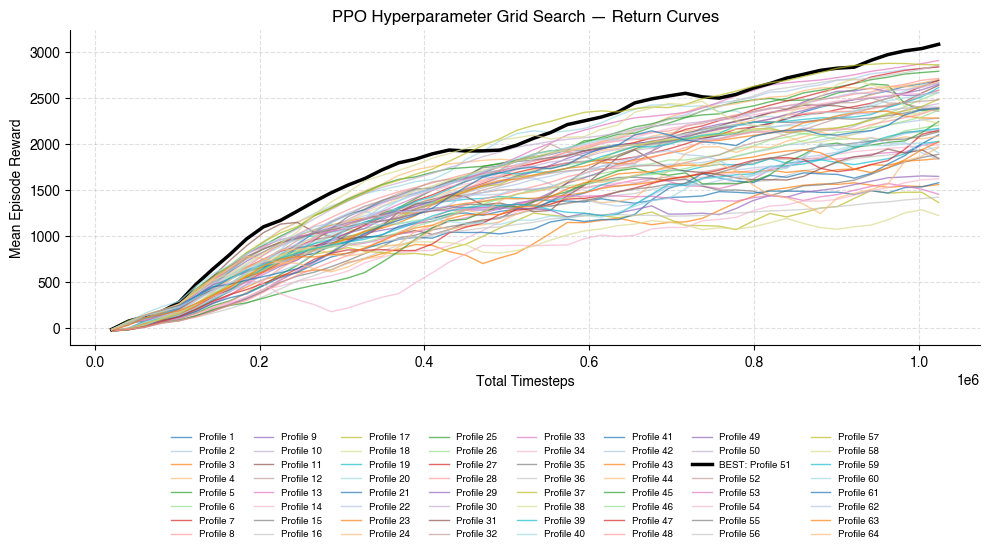

In [84]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# Config
# -----------------------------
BASE_LOGDIR = Path("logs_grid")                       # parent folder containing run subfolders
SUMMARY_CSV = BASE_LOGDIR / "grid_results_master.csv" # grid search summary file
CURVE_XCOL  = "time/total_timesteps"
CURVE_YCOL  = "rollout/ep_rew_mean"


# -----------------------------
# Load summary & print best row
# -----------------------------
if not SUMMARY_CSV.exists():
    raise FileNotFoundError(f"Summary CSV not found: {SUMMARY_CSV}")

summary_df = pd.read_csv(SUMMARY_CSV)
summary_df = summary_df[summary_df["mean_eval_return"].notna()]  # drop NaNs / failed entries

if summary_df.empty:
    raise RuntimeError("Summary CSV contains no successful runs with mean_eval_return.")

best_row = summary_df.loc[summary_df["mean_eval_return"].idxmax()]

print("=== Best Hyperparameter Configuration ===")
print(f"Mean Eval Return: {best_row['mean_eval_return']:.2f}")
for col in summary_df.columns:
    if col not in ("mean_eval_return", "seed", "logdir"):
        print(f"{col}: {best_row[col]}")
print(f"\nLog directory: {best_row['logdir']}\n")


# -----------------------------
# Load individual run curves
# -----------------------------
runs = []        # list of (run_name, run_df)
run_dirs = sorted([p for p in BASE_LOGDIR.iterdir() if p.is_dir()])

for run_dir in run_dirs:
    csv_path = run_dir / "progress.csv"
    if not csv_path.exists():
        continue
    try:
        run_df = pd.read_csv(csv_path)
        if CURVE_XCOL in run_df.columns and CURVE_YCOL in run_df.columns:
            runs.append((run_dir.name, run_df[[CURVE_XCOL, CURVE_YCOL]].copy()))
    except Exception as e:
        print(f"Skipping {run_dir.name}: {e}")

if not runs:
    raise RuntimeError(f"No valid {CURVE_XCOL}/{CURVE_YCOL} found in any progress.csv under {BASE_LOGDIR}.")


# -----------------------------
# Identify best curve (by final Y)
# -----------------------------
final_values = []
for i, (_, rdf) in enumerate(runs):
    y = rdf[CURVE_YCOL]
    if len(y) == 0:
        final_values.append((-np.inf, i))
    else:
        final_values.append((y.iloc[-1], i))

_, best_idx = max(final_values, key=lambda t: t[0])


# -----------------------------
# Colors (up to many runs)
# -----------------------------
def color_cycle(n: int):
    # tab20 has 20 colors; repeat as needed
    base = plt.cm.tab20(np.linspace(0, 1, 20))
    reps = int(np.ceil(n / len(base)))
    return np.tile(base, (reps, 1))[:n]

colors = color_cycle(len(runs))


# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 6))

for i, (name, rdf) in enumerate(runs):
    x = rdf[CURVE_XCOL]
    y = rdf[CURVE_YCOL]

    label = f"Profile {i+1}"
    if i == best_idx:
        # highlight BEST
        plt.plot(x, y, color="black", linewidth=2.5, label=f"BEST: {label}")
    else:
        plt.plot(x, y, color=colors[i], alpha=0.7, linewidth=1.0, label=label)

plt.xlabel("Total Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("PPO Hyperparameter Grid Search — Return Curves")

plt.legend(
    bbox_to_anchor=(0.5, -0.25),
    loc="upper center",
    ncol=8,
    fontsize=7,
    frameon=False
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [10]:
import gymnasium as gym
from stable_baselines3 import PPO
import time
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

MODEL_PATH = "ckpt_grid/BEST_overall.zip"

# Initialize environment and model
env = gym.make("HalfCheetah-v4", render_mode="human")
model = PPO.load(MODEL_PATH, device="cpu")

start_time = time.time()

try:
    while True:
        done = truncated = False
        obs, info = env.reset()
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            time.sleep(0.05)  # control playback speed
except KeyboardInterrupt:
    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f"\nSimulation interrupted after {mins:.0f} min {secs:.1f} sec.")
finally:
    env.close()
    print("Environment closed.")

FileNotFoundError: [Errno 2] No such file or directory: 'ckpt_grid/BEST_overall.zip.zip'

### Thoughts on the Hyperparameters

I performed a systematic grid search over seven PPO hyperparameters to understand their influence on learning performance in the HalfCheetah-v4 environment. Though runtime constraints limited the number of updates per configuration and prevented multiple seeds per setting, the process (combined with the theory learnings from class) gave me a decent intuition for how each parameter shapes learning stability, exploration, and reward progression.

* **Learning rate** – I noticed that lower learning rates (e.g., $2.5\times10^{-5}$) led to smoother but slower improvement, while slightly higher rates made training more responsive early on. I found the model somewhat robust to this range, but too low a rate sometimes caused stagnation.

* **Discount factor** – Runs with higher $\gamma$ values (0.99) tended to produce more stable forward locomotion, as the agent valued long-term momentum. When I lowered $\gamma$ to 0.98, the cheetah moved _slightly_ less consistently and seemed to often prioritize short-term rewards.

* **GAE lambda** – I observed that mid-range values (~0.95–0.97) produced more balanced learning. Lower $\lambda$ made updates noisier, while higher ones slightly slowed adaptation after major policy shifts.

* **Clip range** – A wider clip (0.2) helped accelerate learning initially but sometimes resulted in unstable oscillations; the narrower clip (0.1) was more conservative but gave steadier returns.

* **Number of steps per update** – Increasing to 2048 improved gradient stability and average return, confirming that more on-policy samples per batch help with MuJoCo’s high-variance dynamics. I did not run a grid search over this hyperparameter to save some compute time, as I had a stronger intuition as to how it would affect learning.

* **Entropy coefficient** – A small entropy bonus (0.0004) slightly improved exploration early on. Too little entropy (0.0001) made the policy converge faster but occasionally to suboptimal gait patterns, and the returns fell off.

* **Value function coefficient** – I didn’t observe drastic sensitivity in this range, but higher values (1.0) seemed to stabilize training in some runs, suggesting a modest benefit from stronger value loss weighting. I'll have to test more hyperparameters to be able to say concretely.


I found that $\gamma = 0.99$, $\lambda = 0.95$, clip = 0.1–0.2, and $n_\text{steps} = 2048$ produced the most consistent learning across seeds. The best-performing configuration achieved the highest mean evaluation return (see printout in the cell before this). Even though the grid was coarse and limited by runtime (~10–11 minutes per run), it gave me a good intuition for how PPO’s interplay of bias–variance tradeoffs and policy clipping affects continuous control tasks.